# Import Package

In [1]:
! pip install pycountry
! pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 21.0 MB/s eta 0:00:00


In [2]:
# import packages
import requests
import pycountry
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV, \
GridSearchCV

# expand the output views of panda
pd.set_option('display.max_rows', 50)

# Functions Utilized

### Data Processing Functions

In [3]:
# This function is used to clean messy job title
def clean_job_title(x):
  dictionary_job = {'Data DevOps Engineer': 'Data Developer', \
                    'Data Modeler': 'Data Modeller', \
                    'Financial Data Analyst': 'Finance Data Analyst', \
                    'Head of Data Science': 'Head of Data', \
                    'ML Engineer': 'Machine Learning Developer', \
                    'MLOps Engineer': 'Machine Learning Developer'}
  if x in dictionary_job.keys():
    return dictionary_job[x]
  return x

# This function classifies job title into 17 general jobs
def categorize_job(x):
  for i in ['Scientist', 'Engineer', 'Analyst', 'Manager', 'Developer', \
            'Director', 'Architect', 'Consultant', 'Head', 'Lead', \
            'Specialist', 'Programmer', 'Modeller', 'Researcher', \
            'Practitioner', 'Technician', 'Strategist']:
    if i in x:
      return i
  return x

# this function calculates real-time salary in USD
def real_time_salary(df):
  # request real-time exchange rates API
  url = 'https://api.exchangerate-api.com/v4/latest/USD'
  rates = requests.get(url).json()['rates']
  # calculate salary in us dollar and update salary_in_usd column
  return df['salary'].div(df['salary_currency'].apply(lambda x: rates[x]))

### EDA Functions

In [4]:
# All graphs/tables generated from this cell are used in our presentation

# color attribute of graphs
color_graph = ['#fcedbe', '#f7cf83', '#ef836c', '#f8c9d5', '#ee84a8', '#d35b7e']
color_one = '#c2d7f3'
color_two = '#f7cf83'

#relationship between average salary and experience level
def graph_experience_level(df):
    # Group the data by experience level and calculate the average salary
    experience_salary = df.groupby('experience_level')['salary_in_usd'].mean()\
    .reset_index().sort_values(by='salary_in_usd', ascending=False)

    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.bar(experience_salary['experience_level'], \
                  experience_salary['salary_in_usd'], color=color_graph)

    ax.set_xlabel('Experience Level', fontsize=20)
    ax.set_ylabel('Average Salary', fontsize=20)
    ax.set_title('Average Salary Based on Experience Level', fontsize=25)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))
    plt.show()


#remote_ratios: bar chart
def graph_remote_ratio_bar(df):
    # Bar plot for mean salary
    mean_salary = df.groupby('remote_ratio')['salary_in_usd'].mean()
    mean_salary.index = pd.Index(['No remote', 'Hybrid', 'Fully remote'])
    fig, ax = plt.subplots(figsize=(12, 8))  # Adjust figure size as needed
    ax.bar(mean_salary.index, mean_salary, color=color_one)

    ax.set_xlabel('Remote Ratio', fontsize=20)
    ax.set_ylabel('Average Annual Salary ($)', fontsize=20)
    ax.set_title('Average Salary for Remote Ratios', fontsize=25)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))

    plt.show()

# Example usage
# graph_remote_ratio_bar(your_dataframe, your_color_one)


def graph_remote_hist(df):
  # Box plot for salary based on employment type
  ratio = [0,50,100]
  i = 0
  for remote_ratio, color in zip(['No remote', 'Hybrid', 'Fully remote'], \
                                 color_graph[-3:]):
      subset = df[df['remote_ratio'] == ratio[i]]
      plt.hist(subset['salary_in_usd'], bins=20, alpha=0.3, label=remote_ratio,\
               color=color)
      i += 1

  plt.xlabel('Salary ($)', fontsize=20)
  plt.ylabel('Frequency', fontsize=20)
  plt.title('Histogram of Salary Based on Remote Ratio', fontsize=20)
  plt.tick_params(axis='x', labelsize=15)
  plt.tick_params(axis='y', labelsize=15)
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={"size": 15})
  plt.show()


# job_title(113)/job_category(17)
def graph_job_category(df):
    mean_salary = df.groupby('job_category')['salary_in_usd'].mean()\
    .sort_values(ascending=False)
    x = mean_salary.index
    num = df['job_category'].value_counts()[x]

    fig, ax1 = plt.subplots(figsize=(20, 5))

    ax1.bar(x, mean_salary, color=color_one)
    ax1.set_ylabel('Average Annual Salary ($)', color='cornflowerblue', fontsize=20)

    ax2 = ax1.twinx()
    ax2.plot(x, num, color='darkgoldenrod')
    ax2.set_ylabel('Number of People with Job', color='darkgoldenrod', fontsize=20)

    # Increase the font size of x-axis tick labels
    ax1.tick_params(axis='x', labelrotation=45, labelsize=20)
    ax1.tick_params(axis = 'y', labelsize = 15)
    ax2.tick_params(axis = 'y', labelsize = 15)
    plt.title('Average Salary for Job Categories', fontsize=25, pad=20)
    plt.show()

#salary_in_usd
def graph_salary_distribution(df):
  sorted = np.sort(df['salary_in_usd'])
  culmulative_prob = np.arange(1, len(sorted)+1) / len(sorted)
  plt.fill_between(sorted,culmulative_prob,color = color_one)

  plt.title('Cumulative Distribution for the salary', fontsize=25, pad=20)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.xlabel('Salary', fontsize=20)
  plt.ylabel('Cumulative Distribution', fontsize=20)
  plt.grid(True, color = 'lightgray', alpha = 0.5)
  plt.show()

# company_size_pie_chart
def graph_company_size_pie(df):
  mean_salary = df.groupby('company_size')['salary_in_usd'].mean()\
  .sort_values(ascending = False)
  x = mean_salary.index
  num = df['company_size'].value_counts()[x]
  colors = color_graph
  plt.pie(num, labels=num.index, autopct='%1.1f%%', startangle=140, \
          colors = colors)
  plt.title("Proportion of people in different Company Sizes")
  plt.show()


#company_size
def graph_company_size(df):
  mean_salary = df.groupby('company_size')['salary_in_usd'].mean()\
  .sort_values(ascending = False)
  x = mean_salary.index
  num = df['company_size'].value_counts()[x]

  fig, ax1 = plt.subplots(figsize = (15,5))

  ax1.bar(x,mean_salary, color = color_one)
  ax1.set_ylabel('Average Annual Salary ($)', color = 'cornflowerblue', fontsize = 20)
  ax1.tick_params(axis = 'y', labelsize = 15)
  ax1.tick_params(axis = 'x', labelsize = 15)

  ax2 = ax1.twinx()
  ax2.plot(x,num, color = 'darkgoldenrod')
  ax2.set_ylabel('Number of People in Company', color ='darkgoldenrod', fontsize = 20)
  ax2.tick_params(axis = 'y', labelsize = 15)

  plt.title('Average Salary for Company Size', fontsize = 25)
  plt.show()


#work_year
#how the salary changes with the work year for different experience levels
def graph_work_year(df):
    year = df.groupby(['experience_level', 'work_year']).salary_in_usd.mean()\
    .reset_index()

    colors = ['#66c2a5', '#fc8d62', '#8da0cb','#efcfac']
    fig, ax = plt.subplots(figsize=(12, 8))  # Adjust figure size as needed

    for idx, level in enumerate(year.experience_level.unique()):
        subset = year[year.experience_level == level]
        ax.plot(subset['work_year'], subset['salary_in_usd'], label=level, \
                color = colors[idx % len(colors)])

    ax.set_title('Salary Change over Years for Every Experience Level',\
                 fontsize=25)
    ax.set_xlabel('Year', fontsize=20)
    ax.set_ylabel('Salary', fontsize=20)
    ax.set_xticks([2020, 2021, 2022, 2023])
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))

    legend = ax.legend(title='Experience', loc='upper left', bbox_to_anchor=(1, 1), fontsize=15)
    legend.get_title().set_fontsize(20)
    plt.tight_layout()
    plt.show()


#employment_type: 'Full-time', 'Contract', 'Part-time', 'Freelance'
def graph_employment_salary(df):
  employment_salary = df.groupby('employment_type').salary_in_usd.mean()\
  .reset_index()
  employment_salary = employment_salary.sort_values(by='salary_in_usd',\
                                                    ascending=False)
  fig = px.bar(employment_salary,
              x='employment_type',
              y='salary_in_usd',
              color='employment_type',
              labels={
                  'salary_in_usd': 'Average Salary',
                  'employment_type': 'Employment Type'},
              title='Average Salary Based on Employment Type',
              hover_data={
                  'salary_in_usd': ':,.2f',
                  'employment_type': False
              },
              hover_name='employment_type',
              color_discrete_sequence=color_graph)

  fig.update_layout(
        title_font_size=25,  # Adjust title font size here
        xaxis_title_font_size=20,  # Adjust x-axis label font size here
        yaxis_title_font_size=20,   # Adjust y-axis label font size here
        title_x=0.5,
        legend_title_font_size=20,
        legend_font_size=15
    )
  fig.update_xaxes(tickfont=dict(size=15))
  fig.update_yaxes(tickfont=dict(size=15))

  fig.show()


def graph_average_year(df):
  interest_rates = {
      '2020': 2.5,
      '2021': 1.4,
      '2022': 7.5,
      '2023': 6.4
  }

  # Extracting the years and interest rates
  years = [int(date) for date in interest_rates.keys()]
  rates = list(interest_rates.values())

  # Plotting
  fig, ax1 = plt.subplots(figsize=(10, 6))

  year = df.groupby('work_year').salary_in_usd.mean().reset_index()
  # Bar plot for salary
  ax1.bar(year['work_year'], year['salary_in_usd'], color = color_one)
  ax1.set_xlabel('Year of work', fontsize = 20)
  ax1.set_ylabel('Average salary', fontsize = 20)
  ax1.tick_params('y', labelsize=15)

  # Adding title
  plt.title('Average Salary Over Years', fontsize=25)
  plt.xticks(df['work_year'].unique(), fontsize=15)
  # Display the plot
  plt.show()


def feature_distribution(df):
  fig, axs = plt.subplots(5, 2,figsize=(20, 15))
  cnt = 0
  # loop through rows
  for i in range(5):
      # loop through columns
      for j in range(2):
          column = df.drop(columns = ['salary', 'job_title']).iloc[:, cnt]
          # if values are continuous
          if column.dtype == float:
              # draw histogram
              axs[i,j].hist(column, 300, color = color_one)
          else:
              # if values are categorical
              axs[i,j].bar(column.value_counts().index, column.value_counts(), \
                           color = color_one)
              # if unique values are larger than 10, show xticks per 10 xticks
              if len(axs[i,j].get_xticks()) > 10:
                  axs[i,j].set_xticks(axs[i,j].get_xticks()[::len(axs[i,j]\
                                                          .get_xticks())//10])
                  axs[i,j].tick_params(axis='x', labelrotation=45)
          axs[i,j].set_title([" ".join(i.split("_")) for i in df.drop(columns \
                        = ['salary', 'job_title']).columns][cnt], fontsize=20)
          axs[i,j].tick_params(axis='x', labelsize=15)
          axs[i,j].tick_params(axis='y', labelsize=15)
          cnt += 1
  plt.suptitle('Feature Distribution', fontsize = 25)
  plt.tight_layout()
  plt.subplots_adjust(hspace = 0.8)
  plt.show()


def correlation(df):
    corr = []
    # Drop rows with missing values in 'salary'
    df = df.dropna(subset=['salary']).drop(columns = ['job_title', \
                                          'salary_currency', 'salary_in_usd'])

    for col in df.columns:
        if col in ['company_location', 'employee_residence']:
            # Filter groups with more than one entry
            larger_than_1 = df.groupby(col).filter(lambda x: len(x) > 1)
            groups = larger_than_1[col].unique()
            group_values = [larger_than_1[larger_than_1[col] == group]\
             ['salary']for group in groups]
            sst = df['salary'].var() * (len(df) - 1)
            ssb = sst - sum(larger_than_1.groupby(col)['salary'].var() *\
                            (larger_than_1.groupby(col)['salary'].count() - 1))
            eta_squared = ssb / sst
        else:
            groups = df[col].unique()
            group_values = [df[df[col] == group]['salary'] for group in groups]
            sst = df['salary'].var() * (len(df) - 1)
            ssb = sst - sum(df.groupby(col)['salary'].var() * \
             (df.groupby(col)['salary'].count() - 1))
            eta_squared = ssb / sst

        corr.append(eta_squared)

    # Create a DataFrame for the result
    return pd.DataFrame({'Column': df.columns, 'Correlation to Salary': corr})\
    .dropna()


# Group by employment_type, job_title, and remote_ratio
# to calculate average salary
def graph_company_analysis(df):
    grouped_df = df.groupby('job_category')
    job_categories = ['Analyst', 'Developer', 'Engineer', 'Scientist']
    num_categories = len(job_categories)

    # Calculate the number of rows and columns needed for the subplots
    num_rows = (num_categories + 1) // 2  # Round up to the nearest integer
    num_cols = 2

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, \
                             figsize=(20, 10*num_rows))
    color_discrete_sequence=color_graph
    c_idx = 0

    for idx, (name, group) in enumerate(grouped_df):
        if name in job_categories:
            row_idx = idx // num_cols
            col_idx = idx % num_cols
            # find median salary for each unique (employment_tupe, remote_ratio)
            ordered_salary = group.groupby(['employment_type', 'remote_ratio'])\
            .median(numeric_only=True)['salary'].sort_values(ascending=False)
            dict_ratio = {50: 'Hybrid', 0: 'No remote', 100: 'Fully remote'}

            # Plot on the corresponding subplot
            ax = axes[row_idx, col_idx]
            ax.bar(x=list(str(i[0]) + ',\n' + dict_ratio[i[1]] for i in \
                          ordered_salary.index),
                   height=list(ordered_salary.values),
                   label=f'{name}',
                   color = color_discrete_sequence[c_idx])
            ax.set_xlabel('Job Title', fontsize=20)
            ax.set_ylabel('Median Salary', fontsize=20)
            ax.set_title(f'Median Salary for {name}s', fontsize=25)
            ax.tick_params(axis='x', rotation=45)
            ax.set_xticks(range(len(ordered_salary)))
            ax.tick_params(axis = 'x', labelsize=15)
            ax.tick_params(axis='y', labelsize=15)
            c_idx += 1
    fig.suptitle('Company Analysis', fontsize=25)
    # Adjust layout
    plt.tight_layout()
    plt.show()


def company_choice_analysis(df):
  # Group the data by company size and location and calculate the average salary
  grouped_data = df.groupby(['company_size', 'company_location'])['salary']\
  .mean().reset_index()

  # Pivot the data for the heatmap
  pivot_table = grouped_data.pivot('company_size', 'company_location', 'salary')

  colors = ['#ddeff6', '#86c7d6', '#439fbf']
  cmap = ListedColormap(colors)

  # Create the heatmap
  plt.figure(figsize=(20, 8))
  sns.heatmap(pivot_table, cmap=cmap, fmt=".2f", annot_kws={"size":100})

  # Adding titles and labels
  plt.title('Average Salary by Company Size and Location', fontsize = 25)
  plt.xlabel('Company Location', fontsize = 20)
  plt.ylabel('Company Size', fontsize = 20)
  plt.tick_params(axis='x', labelsize=15)
  plt.tick_params(axis='y', labelsize=15)

  plt.show()




In [5]:
# All graphs generated from this cell are not used in our presentation
def graph_total_year(df):
    # Grouping by work year and summing salary
    year = df.groupby('work_year').salary_in_usd.sum().reset_index()

    fig, ax = plt.subplots(figsize=(12, 8))  # Adjust figure size as needed

    bars = ax.bar(year['work_year'], year['salary_in_usd'], \
                  color= color_graph[-3::-1])

    ax.set_title('Total Salary of Each Year', fontsize=25)
    ax.set_xticks(year['work_year'])
    ax.set_xlabel('Year of Work', fontsize=20)
    ax.set_ylabel('Total Salary', fontsize=20)
    # Formatting y-axis to represent currency in thousands
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:\
                                                      f'${int(x/1000000)}M'))
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    legend_labels = [f"{work_year}" for work_year in year['work_year']]
    legend = ax.legend(bars, legend_labels, title='Work Year', fontsize=15, \
              loc='center left', bbox_to_anchor=(1, 0.5))
    legend.get_title().set_fontsize(20)
    plt.tight_layout()
    plt.show()


  #remote_ratio: pie chart
def graph_remote_ratio(df):
    # Rename remote ratio values as characters
    remote_ratio = df['remote_ratio'].replace({
        0: 'No remote',
        50: 'Hybrid',
        100: 'Fully remote'
    })
    remote_counts = remote_ratio.value_counts().reset_index(name='count')
    # Renaming the columns for clarity
    remote_counts.columns = ['remote_ratio', 'count']

    # Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(remote_counts['count'], labels=remote_counts['remote_ratio'], \
            autopct='%1.1f%%', colors=color_graph[:3])
    plt.title('Remote Ratio', fontsize=25)

    plt.show()


def graph_country(df):
  company_count = df['company_location'].value_counts().reset_index()
  company_count.columns = ['company_location', 'count']
  company_count['company_location'] = company_count['company_location']\
  .apply(lambda x: pycountry.countries.get(alpha_2=x).alpha_3)
  custom_color_sequence = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', \
                          '#6a3d9a', '#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f']
  fig = px.choropleth(
      company_count,
      locations='company_location',
      locationmode='ISO-3',
      color='count',
      color_continuous_scale='viridis',
      color_discrete_sequence=custom_color_sequence,
      title='Company Count by Country',
      labels={'count': 'Number of Companies'}
  )
  fig.update_layout(
      geo=dict(
          showframe=False,
          showcoastlines=False,
      ),
      height=500,
      width=1000
  )
  fig.show()


# company location
def company_location(df):
  salary_bins = [0, 100000, 200000, 300000, 400000, float('inf')]
  df_copy = df.copy()
  df_copy['salary_period'] = pd.cut(df['salary_in_usd'], bins=salary_bins)

  location_stats = df_copy.groupby(['company_location', 'salary_period'])\
  .size().reset_index(name='count')
  heatmap_data = location_stats.pivot('salary_period', 'company_location', \
                                      'count')
  heatmap_data = heatmap_data.fillna(0)

  colors = ['#ddeff6', '#a8d8e2', '#86c7d6', '#6cbccf', '#54aec6', '#439fbf']
  salary_periods = ['(0-100k]', '(100k-200k]', '(200k-300k]', '(300k-400k]', \
                    '(400k+]']
  cmap = ListedColormap(colors)

  vmin = 0
  vmax = 50

  plt.figure(figsize=(23, 6))
  x_labels = list(heatmap_data.columns)
  sns.heatmap(heatmap_data, annot=True, cmap=cmap, vmin=vmin, vmax=vmax, \
              fmt="d", linewidths=0.5, xticklabels=x_labels, \
              yticklabels=salary_periods, annot_kws={"size":10})
  plt.title('Salary Heatmap by Company Location and Period', fontsize = 25)
  plt.tick_params(axis='x', labelsize = 15)
  plt.tick_params(axis='y', labelsize = 15)
  plt.xlabel('Company Location', fontsize = 20)
  plt.ylabel('Salary Period', fontsize = 20)
  plt.show()




### Model Functions

In [6]:
# This cell contains all method used in Model
# function that takes in dataframe, returns training and testing data
def genetrating_train_test(df):

  # One-hot encoding categorical data
  def one_hot(df, cat_col):
    categories = []
    # find unique categories in each categorical data
    for c in cat_col:
      categories.append(list(df[c].value_counts().index))
    dict_one_hot = {}
    # loop through each categorical data
    for i in range(len(cat_col)):
      # loop through each category
      for category in categories[i]:
        # one hot encoding each category
        dict_one_hot[f"{cat_col[i]}_{category}"] = \
         (df[cat_col[i]]== category)
    # generate one-hot-encoding dataframe that contains all unique categories
    categories_df = pd.DataFrame.from_dict(dict_one_hot)
    return categories_df
  # Categorical Columns in our dataframe
  cat_col = ['experience_level', 'employment_type', 'job_title', \
                         'salary_currency', 'employee_residence', \
                         'company_location', 'company_size', 'job_category']
  # generate X by dropping the categorical data and salary,
  # then concat the one-hot encoded features
  X = pd.concat([df.drop(columns = ['salary','salary_in_usd']+cat_col), \
                 one_hot(df, cat_col)], axis = 1)
  # generate y
  y = df['salary_in_usd']
  # train-test-split data by 3:7
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,\
                                                      random_state=66)
  return X_train, X_test, y_train, y_test



# model evaluation
def performance_evalution(prediction_train, actual_train, prediction_test, actual_test):
    Mean_squared_error_for_train = ((prediction_train - actual_train)**2).mean(axis=0)
    Mean_squared_error_for_test = ((prediction_test - actual_test)**2).mean(axis=0)
    Mean_absolute_error_for_train = (abs(prediction_train - actual_train)).mean(axis=0)
    Mean_absolute_error_for_test = (abs(prediction_test - actual_test)).mean(axis=0)
    R_square_for_train = 1 - ((prediction_train - actual_train)**2).sum(axis=0) / ((actual_train - actual_train.mean(axis=0))**2).sum(axis=0)
    R_square_for_test = 1 - ((prediction_test - actual_test)**2).sum(axis=0) / ((actual_test - actual_test.mean(axis=0))**2).sum(axis=0)
    print("==================Mean Squared Error==================")
    print("Mean squared error for train: ", Mean_squared_error_for_train)
    print("Mean squared error for test: ", Mean_squared_error_for_test)
    print("==================Mean Absolute Error=================")
    print("Mean absolute error for train: ", Mean_absolute_error_for_train)
    print("Mean absolute error for test: ", Mean_absolute_error_for_test)
    print("======================R Squared=======================")
    print("R square for train: ", R_square_for_train)
    print("R square for test: ", R_square_for_test)
    return {
        "Mean Squared Error for Train": Mean_squared_error_for_train,
        "Mean squared error for test": Mean_squared_error_for_test,
        "Mean Absolute Error for Train": Mean_absolute_error_for_train,
        "Mean absolute error for test": Mean_absolute_error_for_test,
        "R Squared for Train": R_square_for_train,
        "R square for test": R_square_for_test}


def graph_model_performance(y, y_predict):
  plt.scatter(y, y_predict, color = color_one)
  plt.plot([0, 400000], [0, 400000], color = 'black', linewidth = 0.8, \
           linestyle = 'dashed')
  plt.xlabel('Salary', fontsize = 20)
  plt.ylabel('Predicted Salary', fontsize = 20)
  plt.tick_params(axis='x', labelsize=15)
  plt.tick_params(axis='y', labelsize=15)
  plt.title('Scatterplot of Salary v.s. Predicted Salary', fontsize = 25)
  plt.show()


def lr_model(X_train, X_test, y_train, y_test):
  # fit trainning data into model
  model_lr = LinearRegression().fit(X_train, y_train)
  # predict X_train, X_test
  y_train_predict = model_lr.predict(X_train)
  y_test_predict = model_lr.predict(X_test)
  evaluation_results = performance_evalution(y_train_predict, y_train, y_test_predict, y_test)
  graph_model_performance(y_test, y_test_predict)
  return model_lr, evaluation_results


def lasso_model(X_train, X_test, y_train, y_test, alphas):
  # using parameter search to find best regression model by lasso regularization
  param_distributions = {'alpha': alphas}
  LassoRegression = Lasso()
  lasso_regressor = RandomizedSearchCV(estimator = LassoRegression, \
                                param_distributions = param_distributions, \
                                       scoring='r2', cv=5, n_jobs = -1)
  # fit trainning data into model
  lasso_regressor.fit(X_train,y_train)
  # find the best model after parameter search
  best_model = lasso_regressor.best_estimator_
  print("alpha:", lasso_regressor.best_estimator_)
  # predict X_train, X_test
  y_train_predict = best_model.predict(X_train)
  y_test_predict = best_model.predict(X_test)
  evaluation_results = performance_evalution(y_train_predict, y_train, y_test_predict, y_test)
  graph_model_performance(y_test, y_test_predict)
  return best_model, evaluation_results


def ridge_model(X_train, X_test, y_train, y_test, alphas):
  # using parameter search to find best regression model by ridge regularization
  param_distributions = {'alpha': alphas}
  RidgeRegression = Ridge()
  ridge_regressor = RandomizedSearchCV(estimator = RidgeRegression, \
                                  param_distributions = param_distributions, \
                                       scoring='r2', cv=5, n_jobs = -1)
  # fit trainning data into model
  ridge_regressor.fit(X_train,y_train)
  # find the best model after parameter search
  best_model = ridge_regressor.best_estimator_
  print("alpha:", ridge_regressor.best_estimator_)
  # predict X_train, X_test
  y_train_predict = best_model.predict(X_train)
  y_test_predict = best_model.predict(X_test)
  evaluation_results = performance_evalution(y_train_predict, y_train, y_test_predict, y_test)
  graph_model_performance(y_test, y_test_predict)
  return best_model, evaluation_results


def dtr_model(X_train, X_test, y_train, y_test):
  # Creating and training the model
  regressor = DecisionTreeRegressor(random_state=42)
  regressor.fit(X_train, y_train)

  # Making predictions and evaluating the model
  y_test_predict = regressor.predict(X_test)
  y_train_predict = regressor.predict(X_train)
  evaluation_results = performance_evalution(y_train_predict, y_train, y_test_predict, y_test)
  graph_model_performance(y_test, y_test_predict)
  return regressor, evaluation_results


def lgbm_model(X_train, X_test, y_train, y_test, gridParams):
  # Initiate LGBM regression to use
  mdl = lgb.LGBMRegressor(boosting_type='gbdt',
                          objective='regression',
                          n_jobs=-1,
                          silent=True,
                          max_depth=-1,
                          max_bin=500)

  # find the best parameter
  grid = GridSearchCV(mdl, gridParams, verbose=2, cv=4, n_jobs=-1)
  grid.fit(X_train, y_train)
  best_model = grid.best_estimator_
  print(best_model.best_estimator_)

  # predict X_train, X_test
  y_test_predict = best_model.predict(X_test)
  y_train_predict = best_model.predict(X_train)

  evaluation_results = performance_evalution(y_train_predict, y_train, y_test_predict, y_test)
  graph_model_performance(y_test, y_test_predict)
  return best_model, evaluation_results




# Import Data

In [7]:
# import dataset
url = 'https://raw.githubusercontent.com/yinyin0916/DSGA-1007-Project/main/salaries.csv'
df = pd.read_csv(url)

In [8]:
# overview of data
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Data Scientist,199000,USD,199000,US,0,US,M
1,2023,SE,FT,Data Scientist,196760,USD,196760,US,0,US,M
2,2023,SE,FT,Machine Learning Engineer,90000,USD,90000,CO,0,CO,M
3,2023,SE,FT,Machine Learning Engineer,70000,USD,70000,CO,0,CO,M
4,2023,SE,FT,ML Engineer,324000,USD,324000,US,0,US,M


# Data Cleaning

In [9]:
# there are 8113 data in our dataset
df.shape

(8113, 11)

In [10]:
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [11]:
# overview of each categorical feature
for i in df.columns:
  if i not in ['work_year', 'salary', 'salary_in_usd']:
    print(i)
    print(df[i].value_counts().sort_index())

experience_level
EN     432
EX     249
MI    1578
SE    5854
Name: experience_level, dtype: int64
employment_type
CT      18
FL      11
FT    8071
PT      13
Name: employment_type, dtype: int64
job_title
AI Architect                       10
AI Developer                       15
AI Engineer                        26
AI Programmer                       6
AI Research Engineer                4
                                   ..
Sales Data Analyst                  1
Software Data Engineer              3
Staff Data Analyst                  3
Staff Data Scientist                2
Staff Machine Learning Engineer     1
Name: job_title, Length: 119, dtype: int64
salary_currency
AUD      10
BRL       4
CAD      36
CHF       5
CLP       1
DKK       3
EUR     325
GBP     304
HKD       1
HUF       3
ILS       1
INR      51
JPY       4
MXN       1
NOK       2
PHP       1
PLN       7
SGD       6
THB       2
TRY       3
USD    7342
ZAR       1
Name: salary_currency, dtype: int64
employee_residence


In [12]:
# clean job_title
df['job_title'] = df['job_title'].apply(clean_job_title)

In [13]:
# based on job_title, we can divide jobs into 17 categories
df['job_category'] = df['job_title'].apply(categorize_job)
df['job_category'].value_counts().sort_values(ascending = False)

Engineer        3435
Scientist       2333
Analyst         1398
Manager          270
Developer        206
Architect        198
Specialist        60
Head              44
Consultant        40
Lead              35
Director          28
Modeller          22
Strategist        16
Researcher        12
Practitioner       8
Programmer         6
Technician         2
Name: job_category, dtype: int64

In [14]:
# rename experience level and employment type
df['experience_level'] = df['experience_level'].replace({
    'SE': 'Senior',
    'EN': 'Entry',
    'EX': 'Executive',
    'MI': 'Mid',
})
df['employment_type'] = df['employment_type'].replace({
    'FT': 'Full-time',
    'PT': 'Part-time',
    'CT': 'Contract',
    'FL': 'Freelance',
})

In [15]:
# change salary into real-time USD
df['salary'] = real_time_salary(df)

In [16]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,8113.000000,8113.000000,8113.000000,8113.000000
mean,2022.715149,149285.718251,149305.354616,39.831135
std,0.559426,64078.116300,64013.143735,48.270212
min,2020.000000,6213.324128,15000.000000,0.000000
25%,2023.000000,105000.000000,105000.000000,0.000000
50%,2023.000000,142200.000000,142200.000000,0.000000
75%,2023.000000,185900.000000,185900.000000,100.000000
max,2023.000000,450000.000000,450000.000000,100.000000


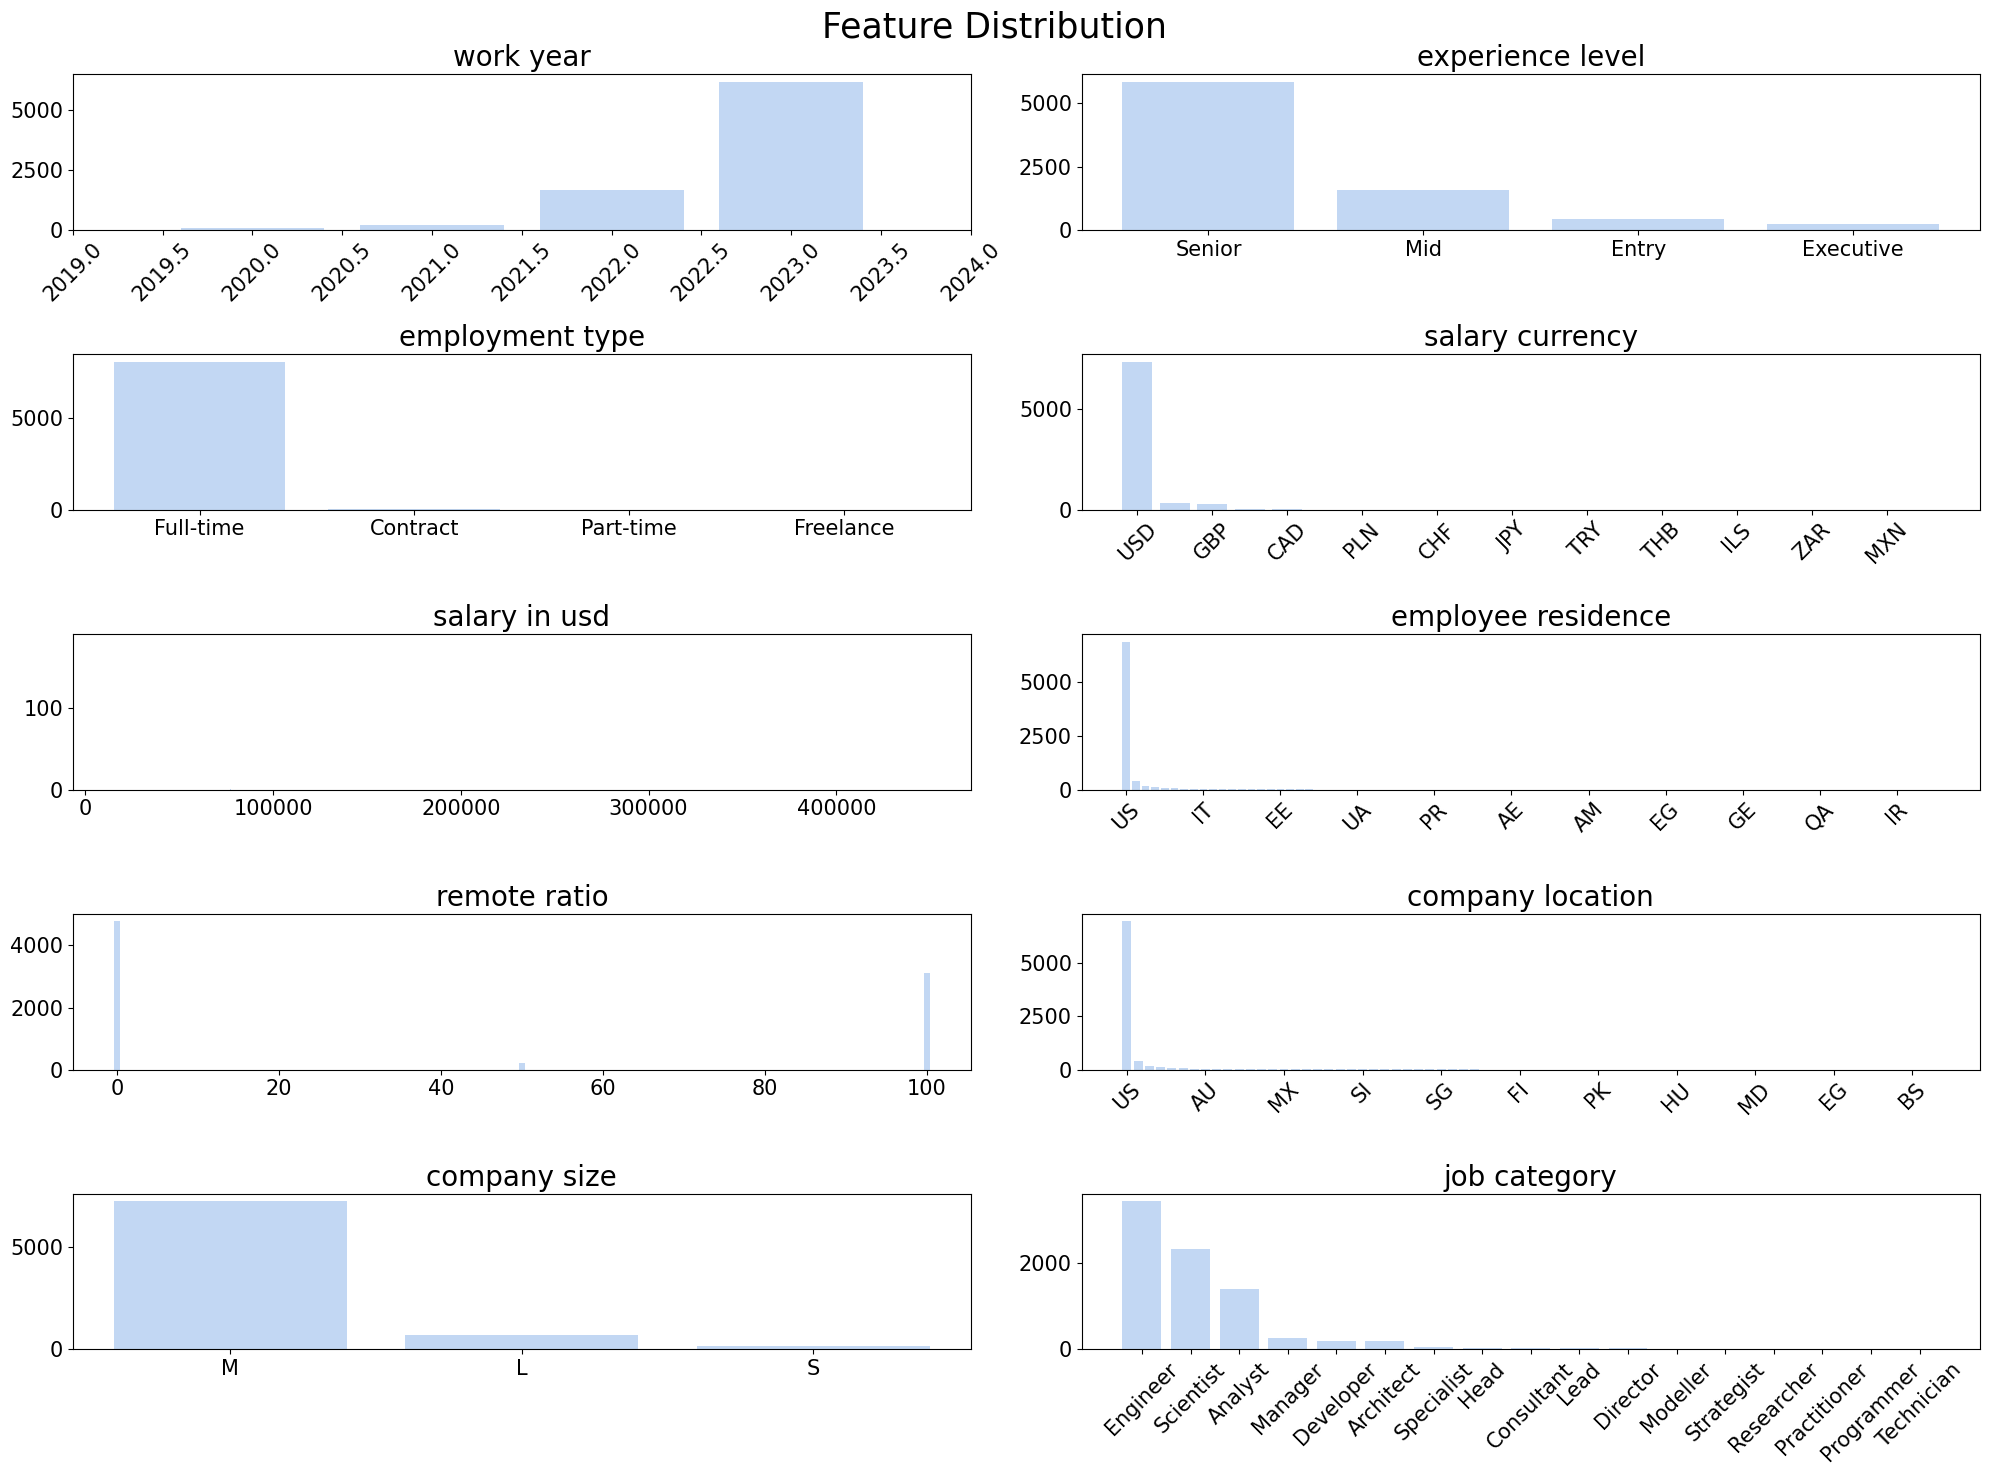

In [17]:
feature_distribution(df)

# Exploratary Data Analysis

## Q1:How does each feature relate to salary?

In [18]:
correlation(df).sort_values(by='Correlation to Salary', ascending = False)

,Column,Correlation to Salary
4,employee_residence,0.178999
6,company_location,0.167216
1,experience_level,0.148314
8,job_category,0.109889
0,work_year,0.041145
5,remote_ratio,0.039230
7,company_size,0.026594
2,employment_type,0.007174


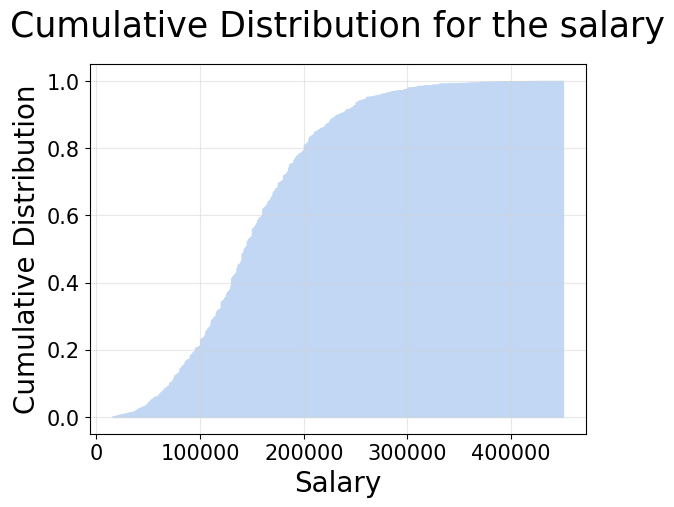

In [19]:
graph_salary_distribution(df)

<!-- Overall, ~20% data-related job having salaries under 100,000, ~50% data-related job having salaries under 150,000, and ~80% data-related job having slaries under 200,000. -->
The median salary is just  200,000, with a steep initial curve suggesting a high concentration of individuals earning lower salaries and a gradual approach to the higher salary range, reflecting income inequality.


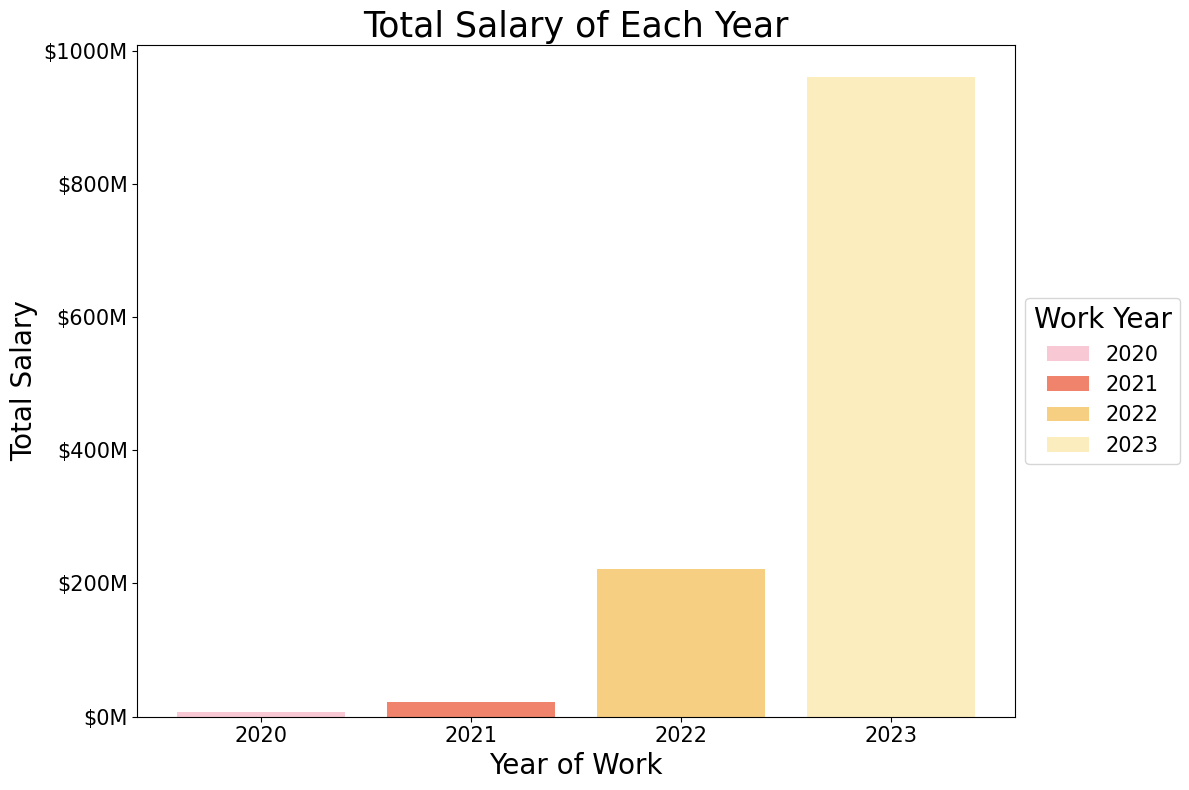

In [20]:
graph_total_year(df)

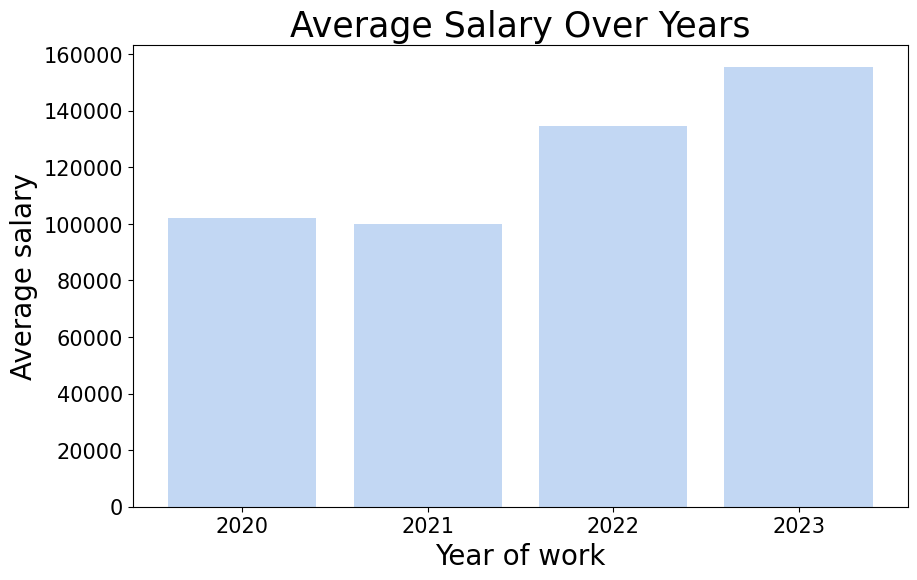

In [21]:
graph_average_year(df)

There is a consistent increase in both the average and total salaries over the years from 2020 to 2023, with a notably steep rise in total salary in 2023 compared to previous years.



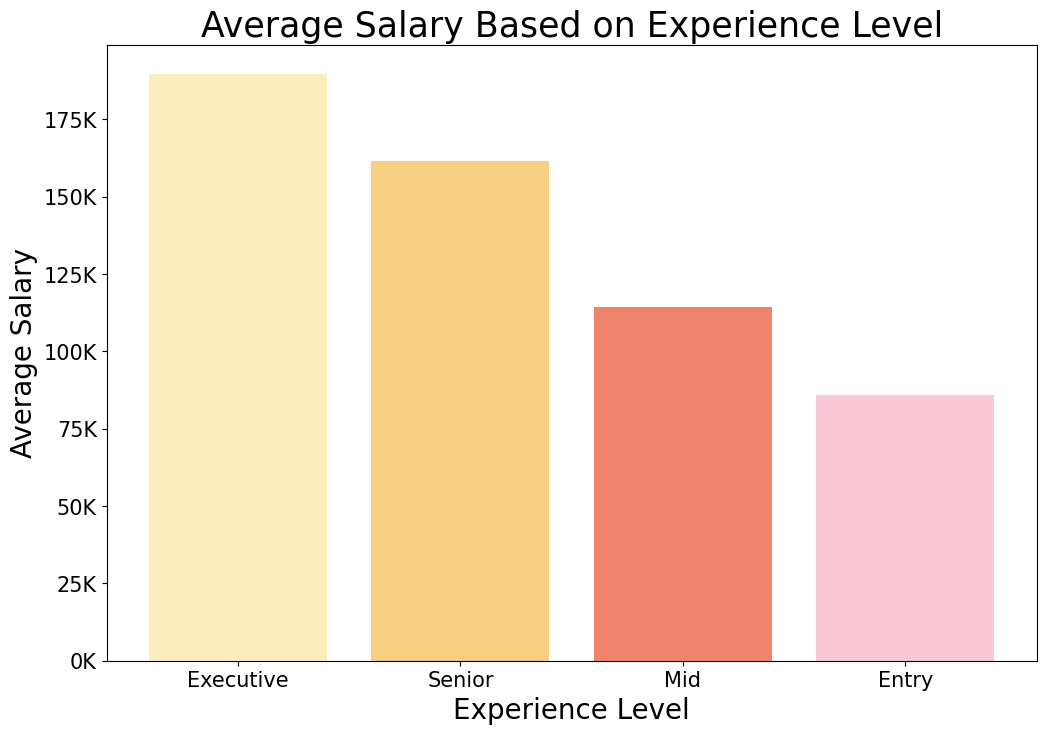

In [22]:
graph_experience_level(df) #Done by Frank

Average salary descends by experience level, with executives earning the highest, followed by senior, mid, and entry-level positions respectively, indicating a correlation between experience and salary.

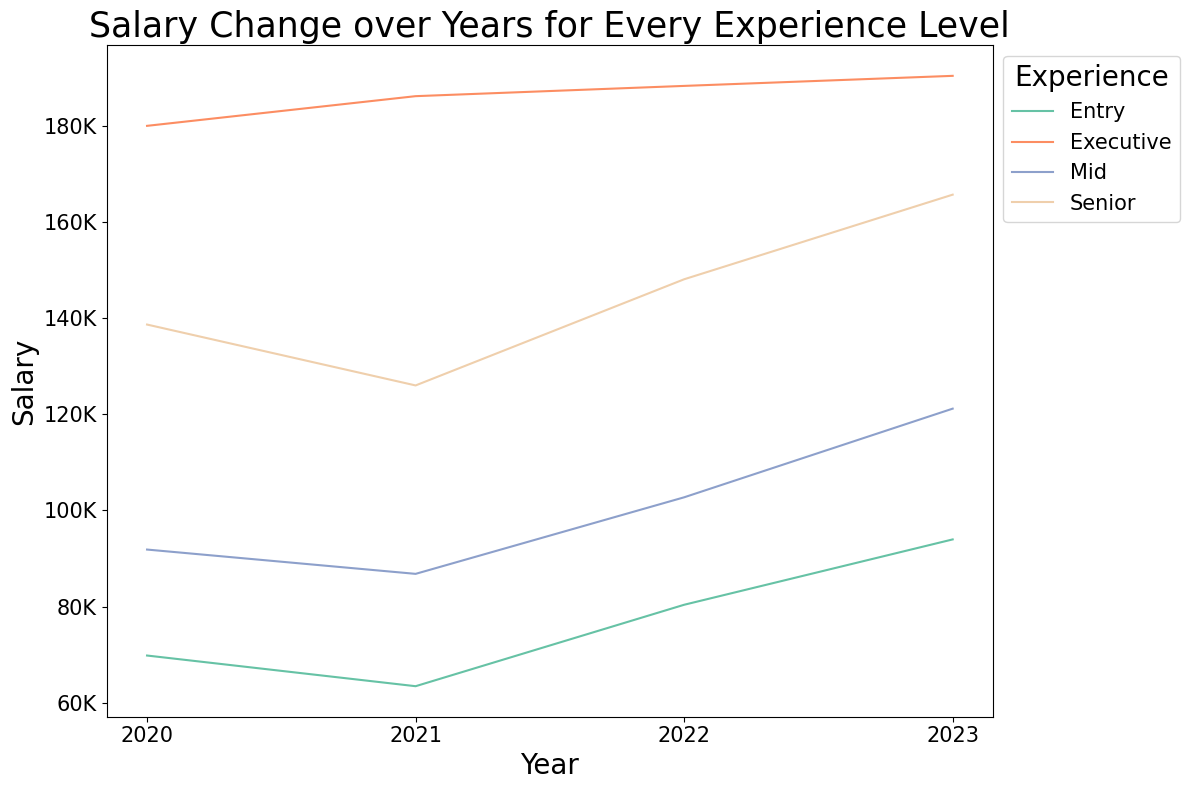

In [23]:
graph_work_year(df)

Salaries increase year-over-year across all experience levels from 2020 to 2023, with executive positions showing the highest salaries throughout and entry-level positions the lowest, yet all demonstrating upward trends.



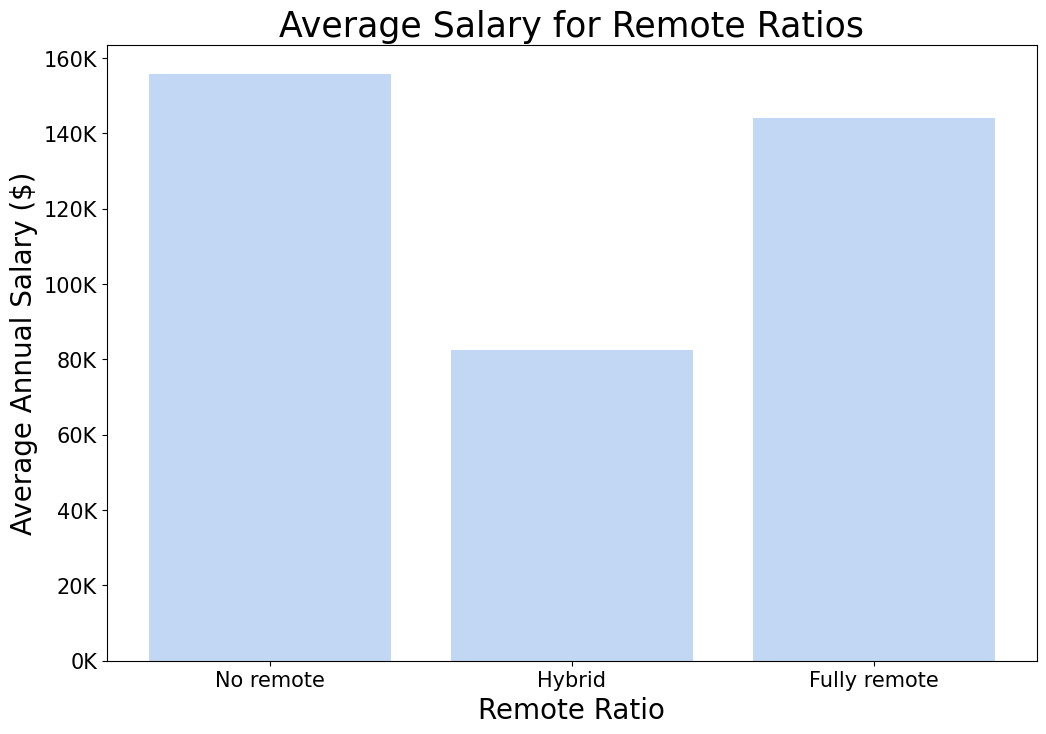

In [24]:
graph_remote_ratio_bar(df)

Employees with no remote work option have the highest average salary, followed closely by those who are fully remote, while employees in hybrid work arrangements have a notably lower average salary.

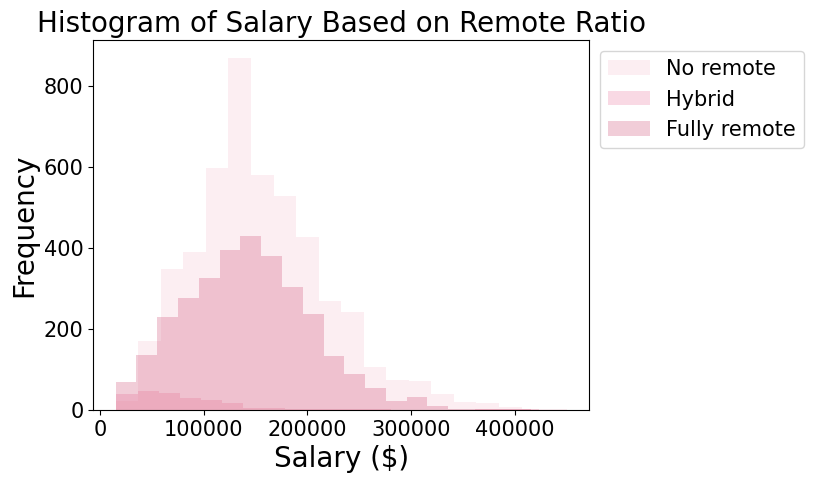

In [25]:
graph_remote_hist(df)

Both distributions are centered around the same salary range, but the 'no remote' group has a higher frequency of salaries in the middle of the distribution, suggesting that more individuals with no remote work option fall into this common salary range. The 'fully remote' distribution seems to be more spread out, indicating a wider variation in salaries for fully remote workers.

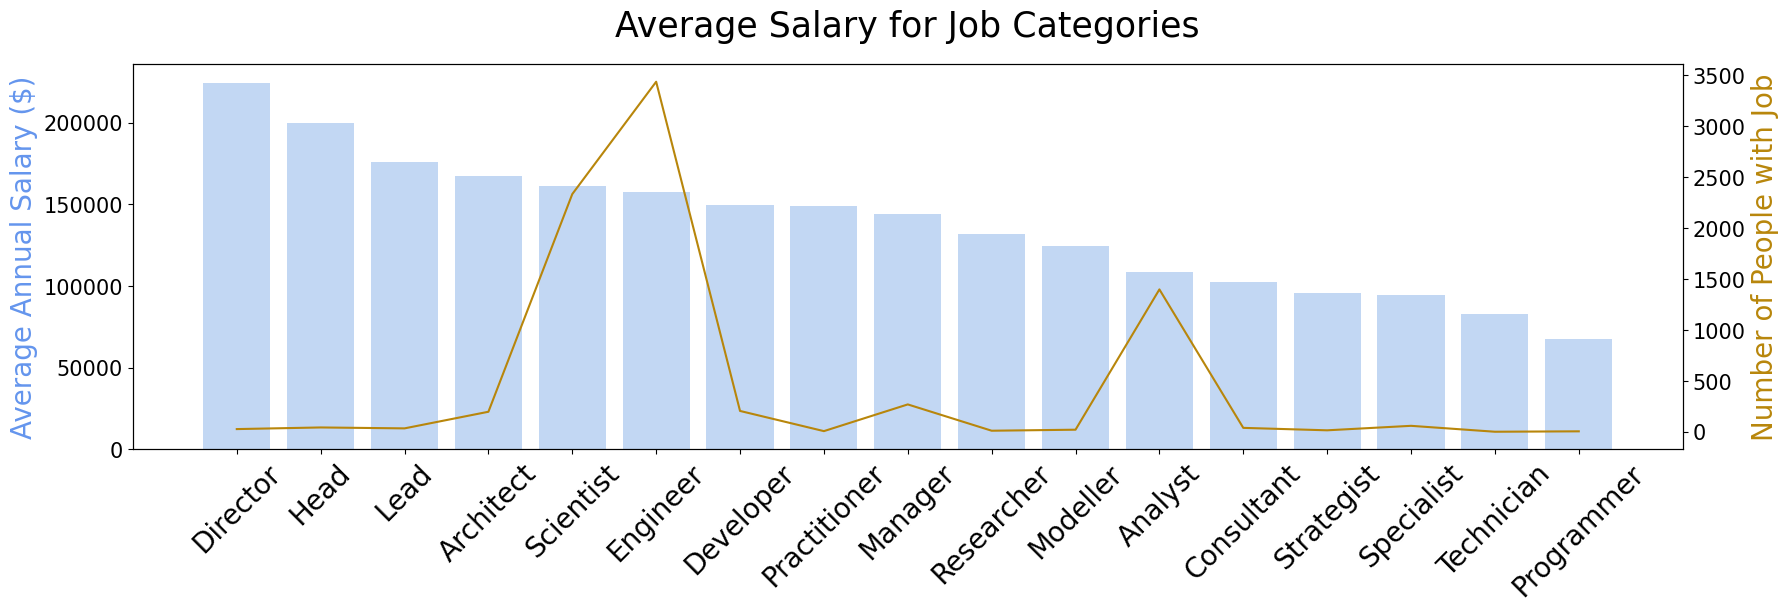

In [26]:
graph_job_category(df)

The dual-axis chart shows that roles like 'Director', 'Lead', and 'Scientist' not only have higher average salaries but also a lower number of individuals in those roles, suggesting a potential scarcity of skilled professionals in higher-paying positions.

In [27]:
graph_country(df)

Majority jobs of our dataset are from US company.

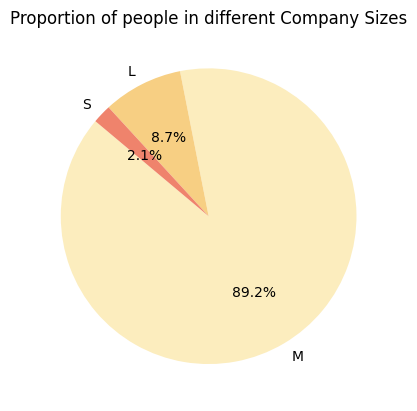

In [28]:
graph_company_size_pie(df)

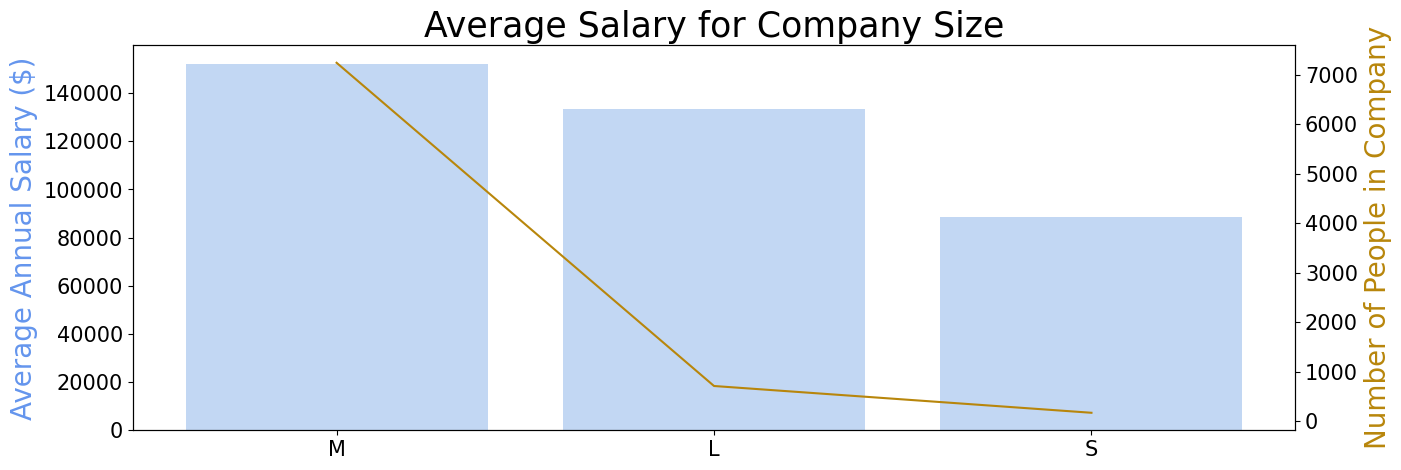

In [29]:
graph_company_size(df)

The two charts, suggests that most people work in medium-sized companies, which also offer the highest average annual salary. Large companies employ a smaller percentage of people and offer a slightly lower average salary than medium-sized companies. Small companies, despite having the smallest workforce, offer the lowest average salary.

In [30]:
graph_employment_salary(df)

Full-time employees have the highest average salary, followed by contract workers, with freelancers and part-time employees earning less on average.

## Q2: If we were to find a job this year (2023), as an entry level and US employee residence, what kind of job should we looking for?

In [31]:
# Find dataset that corresponding to our situation
grad_df = df[(df['work_year'] == 2023) & (df['experience_level'] == 'Entry') & (df['employee_residence'] == 'US')]
grad_df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_category
51,2023,Entry,Full-time,Finance Data Analyst,56500.0,USD,56500,US,50,US,L,Analyst
166,2023,Entry,Full-time,Data Analyst,80000.0,USD,80000,US,0,US,M,Analyst
167,2023,Entry,Full-time,Data Analyst,50000.0,USD,50000,US,0,US,M,Analyst
222,2023,Entry,Full-time,Data Engineer,130916.0,USD,130916,US,0,US,M,Engineer
223,2023,Entry,Full-time,Data Engineer,120000.0,USD,120000,US,0,US,M,Engineer


### What kind of job should we looking for? （Job_category, remote_ratio)

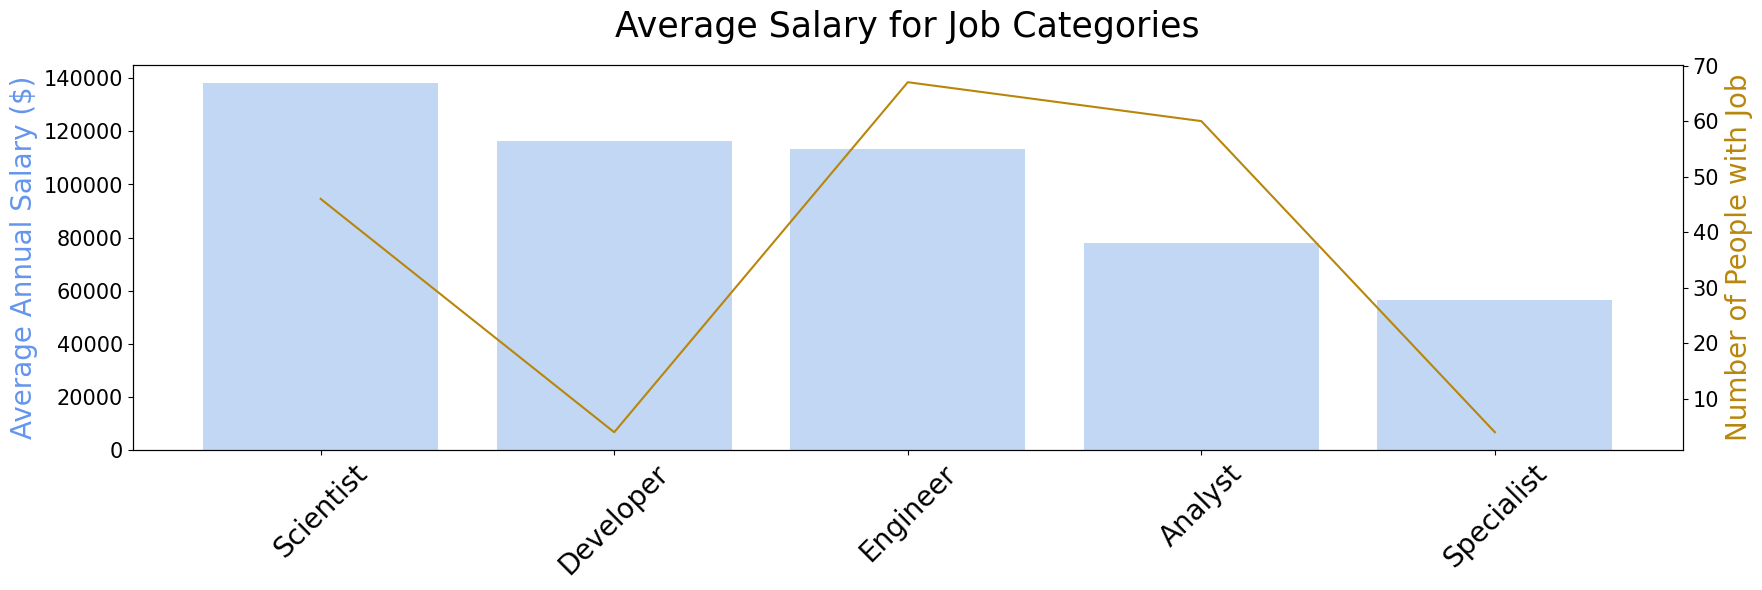

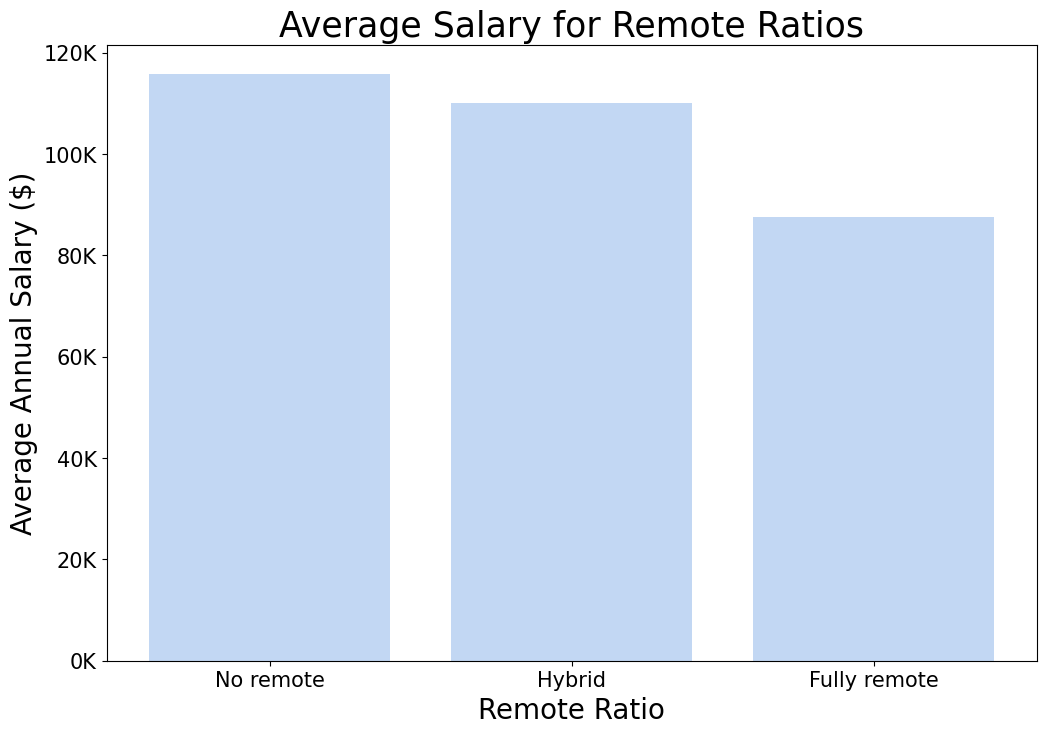

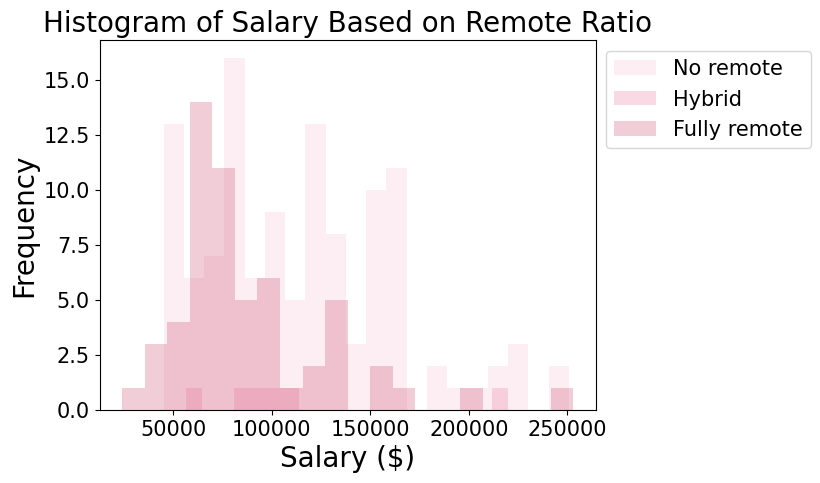

In [32]:
graph_job_category(grad_df)#job_title/job_category
graph_remote_ratio_bar(grad_df)#remote_ratio
graph_remote_hist(grad_df)

Average Salary for Job Categories: Scientists and Developers command the highest average annual salaries among the job categories listed, making them attractive options for those prioritizing income.

Average Salary for Remote Ratios: Employees with no remote work option have the highest average salary, followed by those with hybrid and fully remote options. However, considering the rise in remote and hybrid work's popularity, the choice may also depend on work-life balance preferences.

Histogram of Salary Based on Remote Ratio: The histogram suggests a wider range of salaries for fully remote positions, indicating variability in pay that could be influenced by the job role, industry, or individual negotiation skills.

### Which kind of company should we looking for?(company_location, company size)

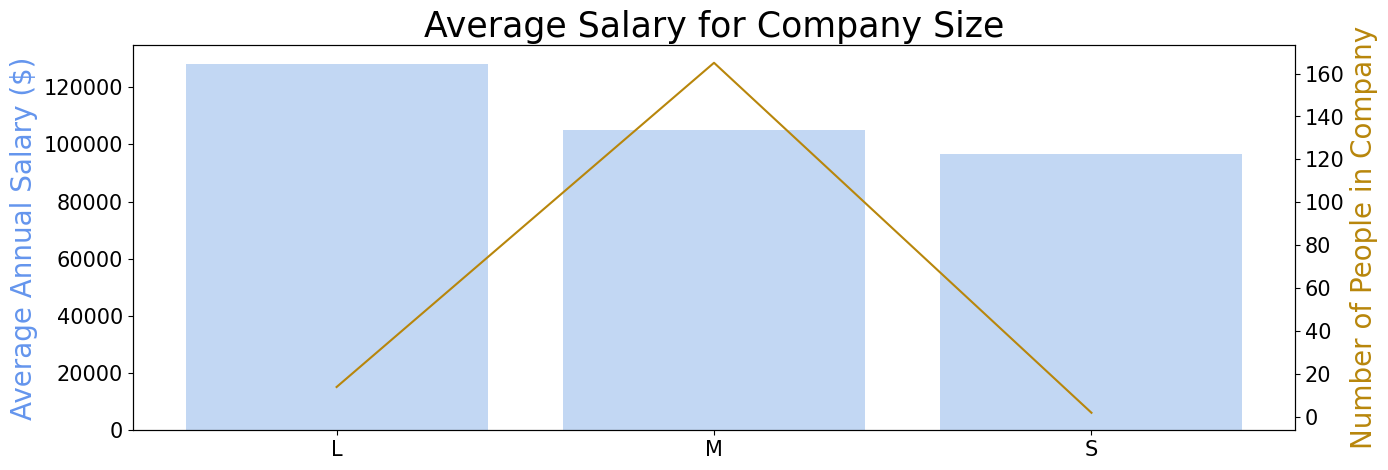

<ipython-input-4-5eae95735f10>:350: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



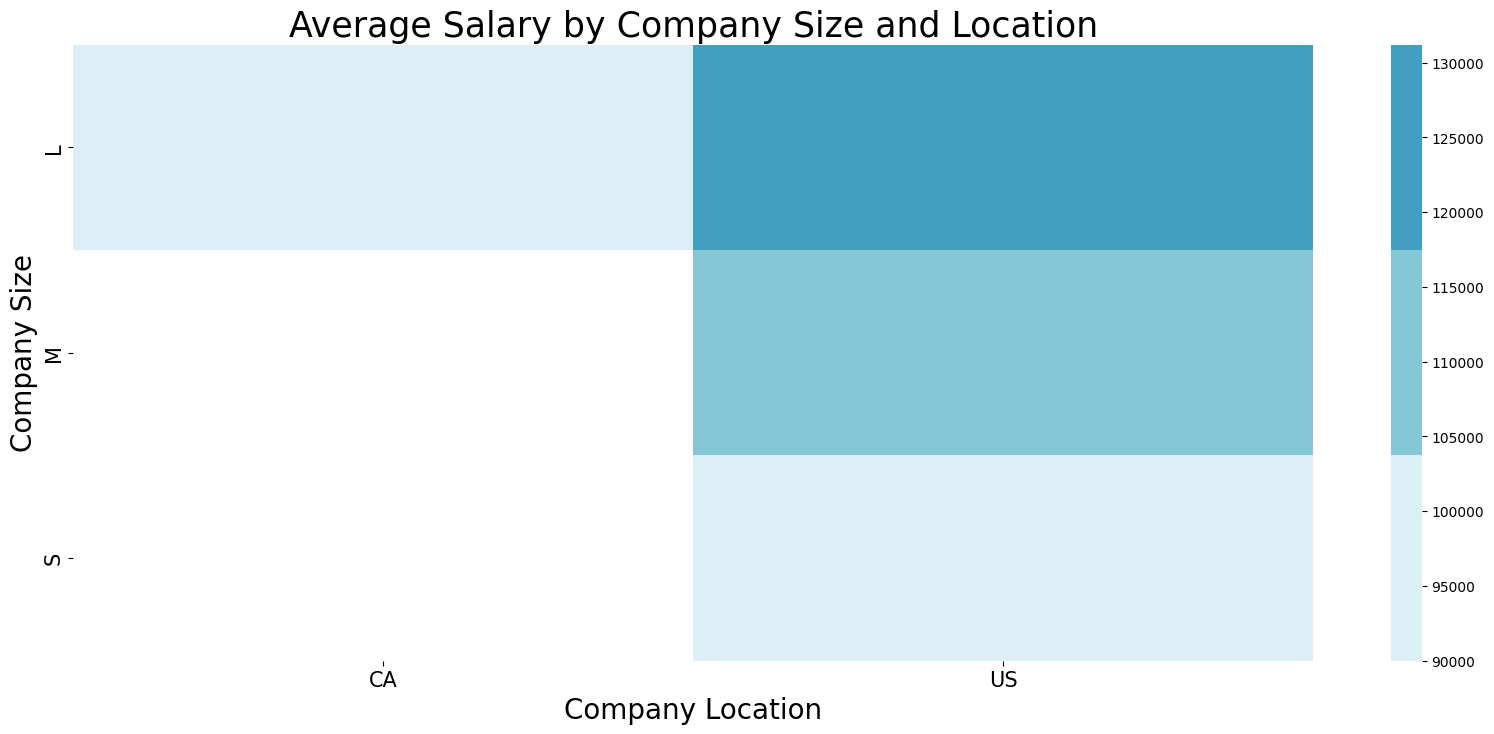

In [33]:
graph_company_size(grad_df)#company_size
company_choice_analysis(grad_df)


Considering the provided data, medium-sized companies in the US seem to offer the highest average salaries. However, large companies, particularly in Canada (CA), also offer competitive salaries that are only slightly less on average. Small companies, despite having a significant number of employees, offer lower average salaries compared to medium and large companies. For the highest potential average salary, a medium-sized company in the US would be the choice indicated by the data.

### Based on different job category, which kind of employment type should we looking for? (employment_type, job_category, remote_ratio)

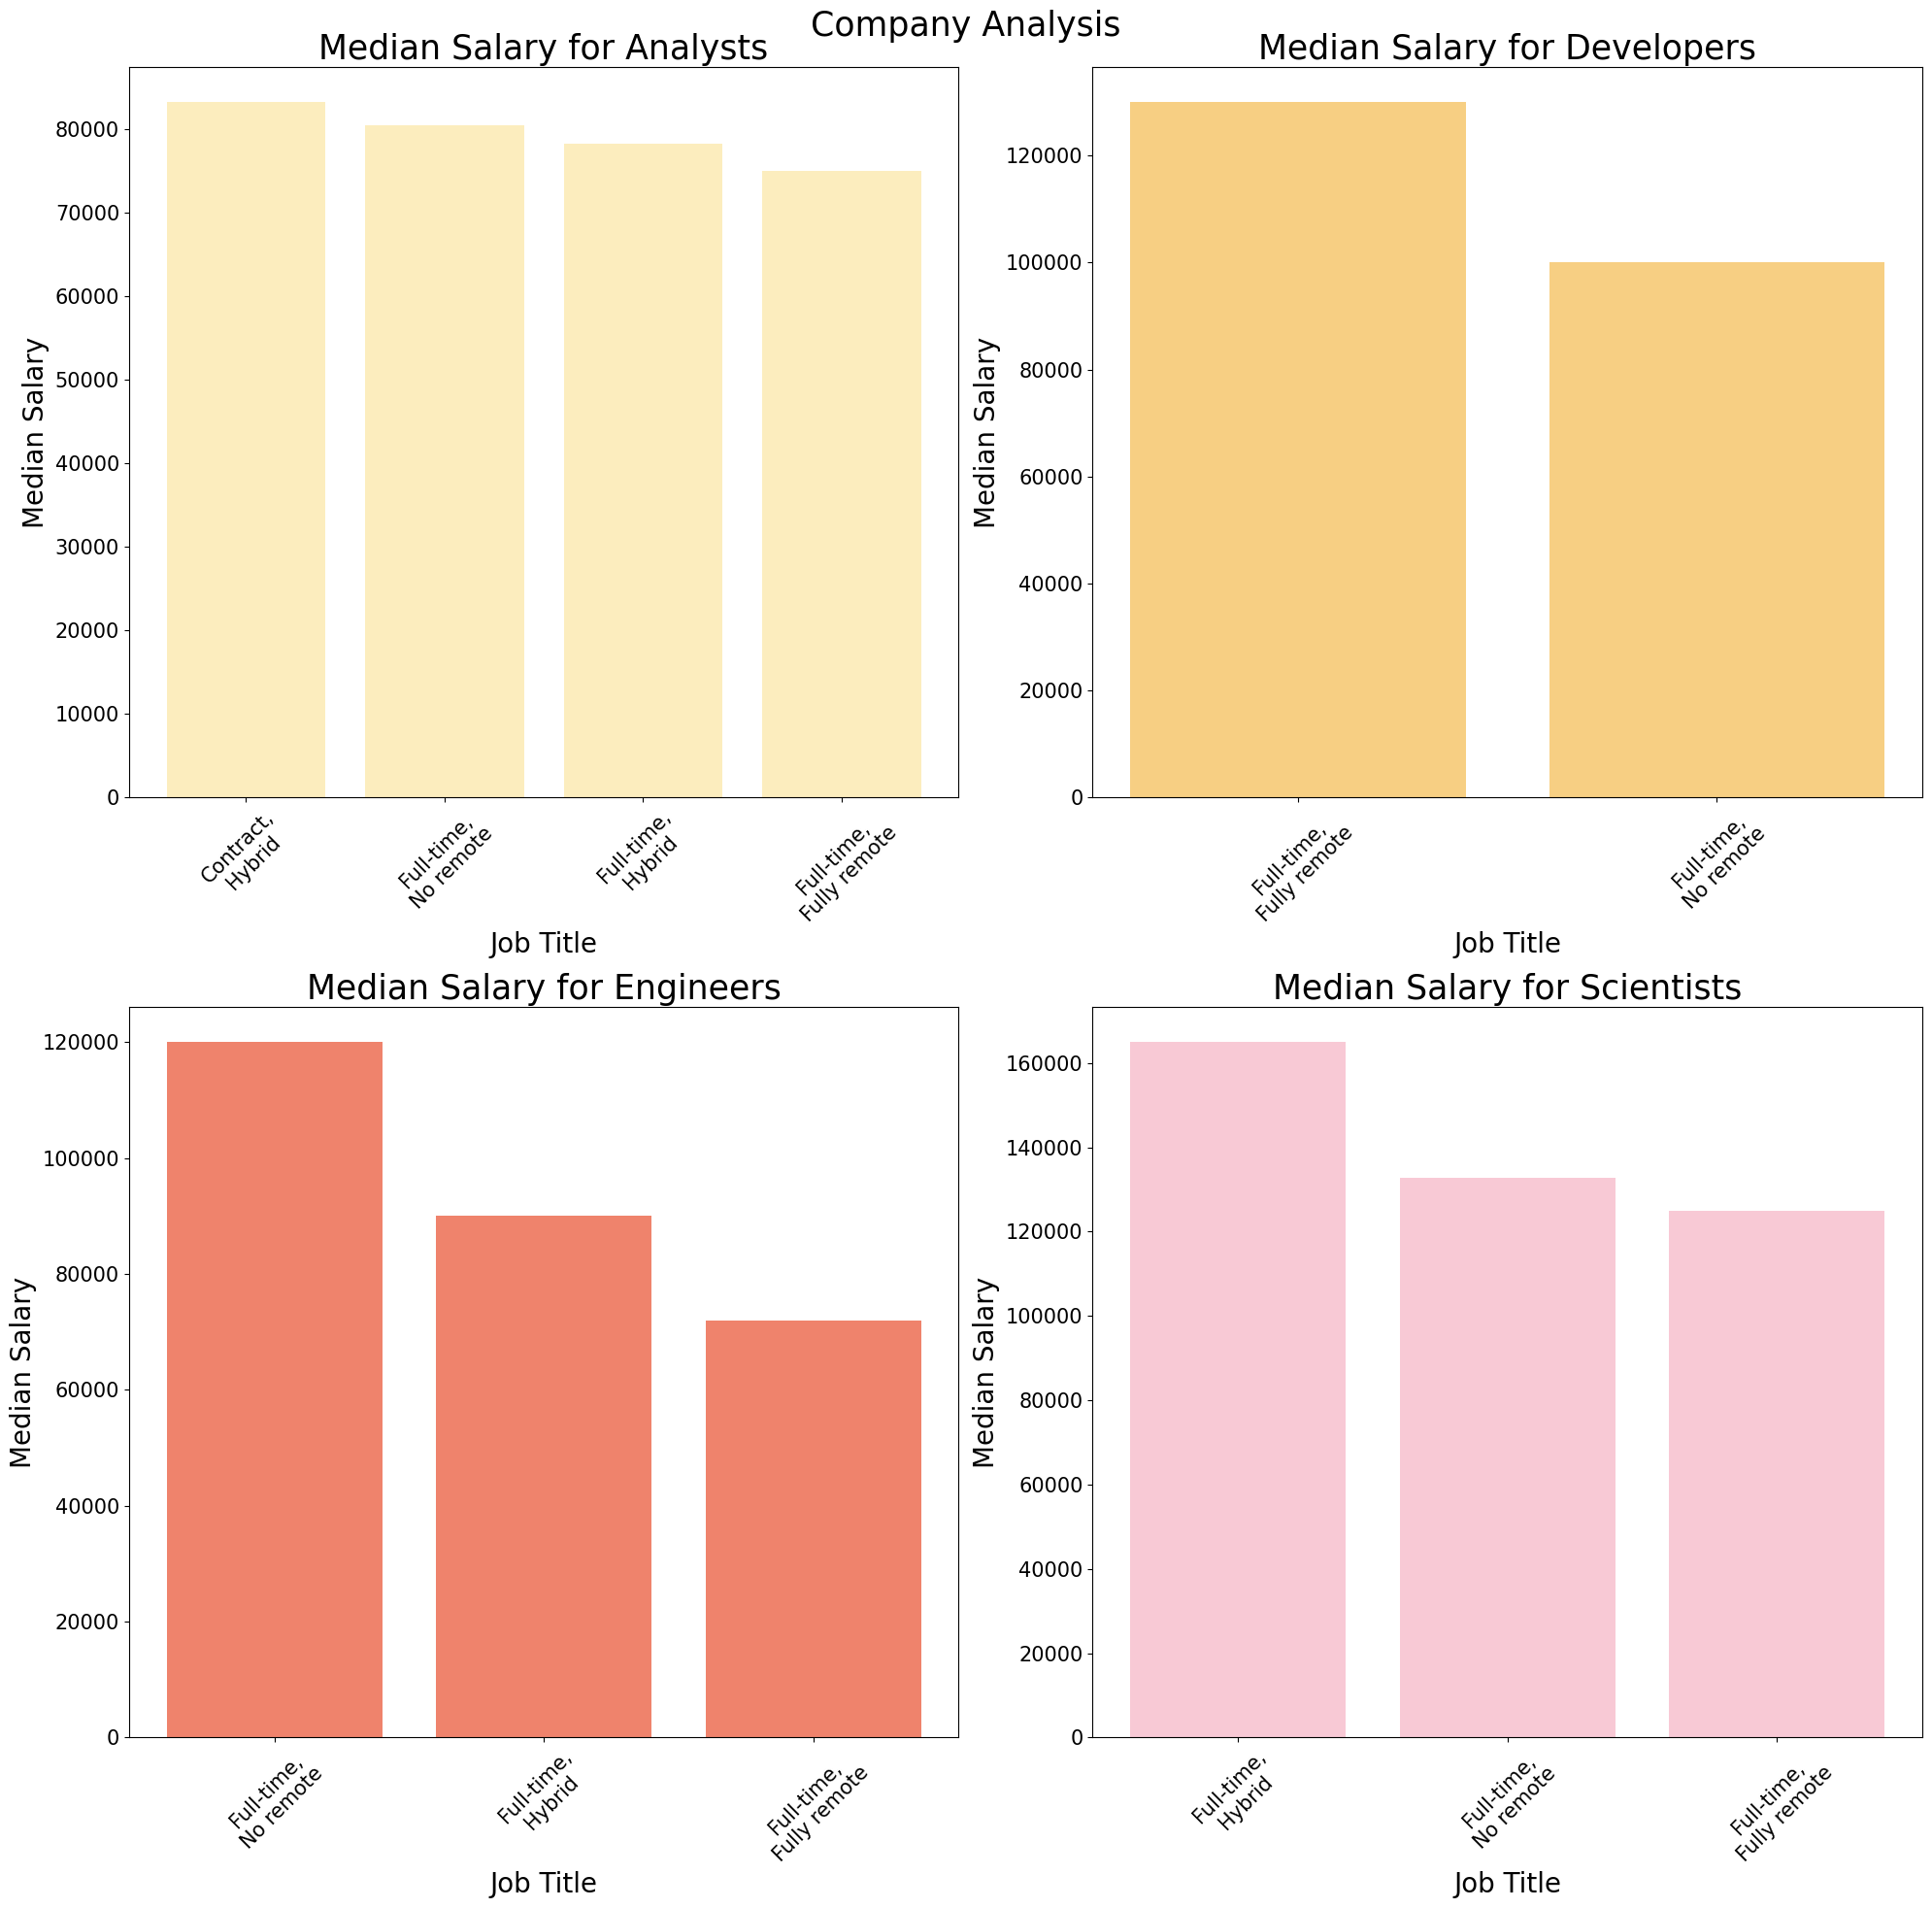

In [34]:
graph_company_analysis(grad_df)

Across all job titles, full-time positions tend to have higher median salaries compared to remote or part-time options, with Developers showing the most significant discrepancy based on employment type.

# Model

In [35]:
# train-test split
X_train, X_test, y_train, y_test = genetrating_train_test(df)
X_train.shape, X_test.shape

((5679, 323), (2434, 323))

## Linear Regression Model (Baseline)

==================Mean Squared Error==================
Mean squared error for train:  2272718433.097979
Mean squared error for test:  1.5376100984485485e+25
==================Mean Absolute Error=================
Mean absolute error for train:  36380.470131185066
Mean absolute error for test:  234301893437.7354
======================R Squared=======================
R square for train:  0.44114219086471684
R square for test:  -3689033294676385.0


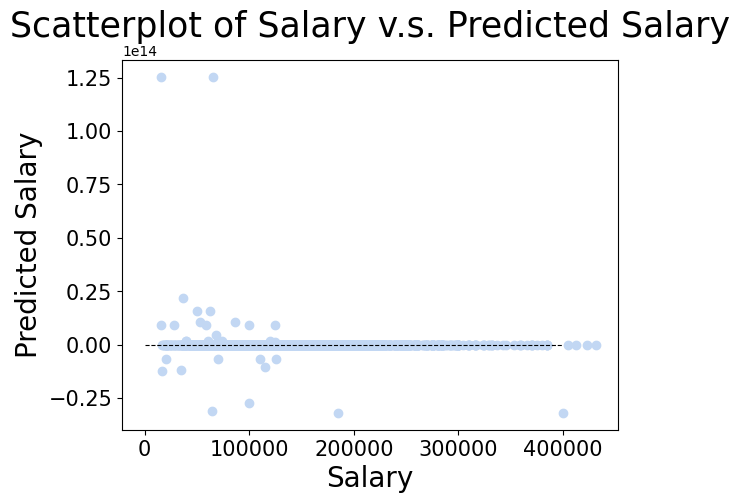

In [36]:
model_lr, results_lr = lr_model(X_train, X_test, y_train, y_test)
results__lr_df = pd.DataFrame([results_lr], columns=results_lr.keys())

## Lasso Regression Model

alpha: Lasso(alpha=33)
==================Mean Squared Error==================
Mean squared error for train:  2367119005.626176
Mean squared error for test:  2616791685.774041
==================Mean Absolute Error=================
Mean absolute error for train:  37378.614703004874
Mean absolute error for test:  38475.72762394789
======================R Squared=======================
R square for train:  0.4179292418359578
R square for test:  0.3721794840061784


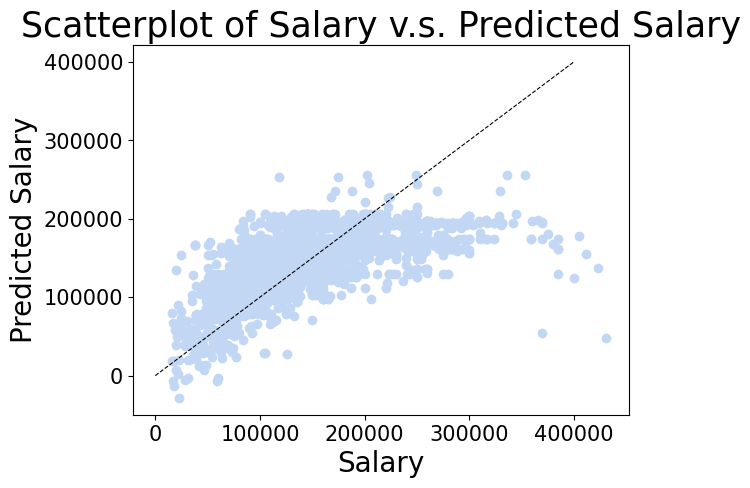

In [37]:
model_lasso, results_lasso = lasso_model(X_train, X_test, y_train, y_test, np.arange(0,100,1))
results__lasso_df = pd.DataFrame([results_lasso], columns=results_lasso.keys())

## Ridge Regression Model

alpha: Ridge(alpha=0.9510000000000001)
==================Mean Squared Error==================
Mean squared error for train:  2285110881.6640806
Mean squared error for test:  2624298484.3098545
==================Mean Absolute Error=================
Mean absolute error for train:  36661.73957108366
Mean absolute error for test:  38521.921447813336
======================R Squared=======================
R square for train:  0.438094907684093
R square for test:  0.37037845331816566


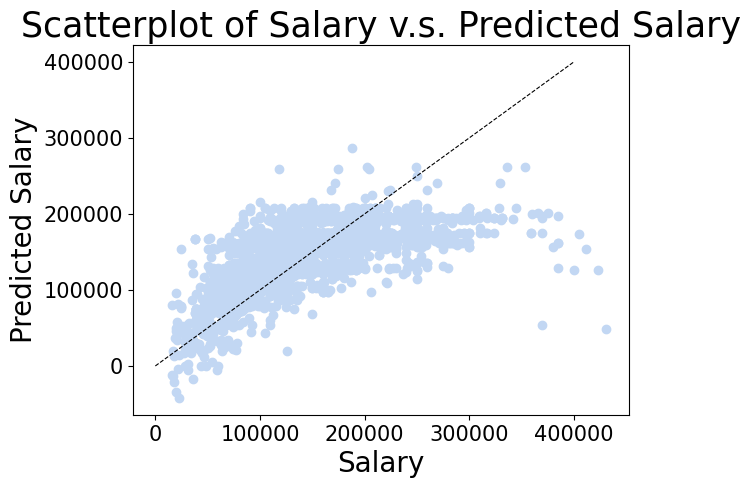

In [38]:
model_ridge, results_ridge = ridge_model(X_train, X_test, y_train, y_test, np.arange(0.001,1,0.05))
results__ridge_df = pd.DataFrame([results_ridge], columns=results_ridge.keys())

## Decision Tree Regressor Model

==================Mean Squared Error==================
Mean squared error for train:  1954094396.3884864
Mean squared error for test:  2801963631.6215615
==================Mean Absolute Error=================
Mean absolute error for train:  32145.718023159814
Mean absolute error for test:  39084.025672413285
======================R Squared=======================
R square for train:  0.5194913292798011
R square for test:  0.3277530410372639


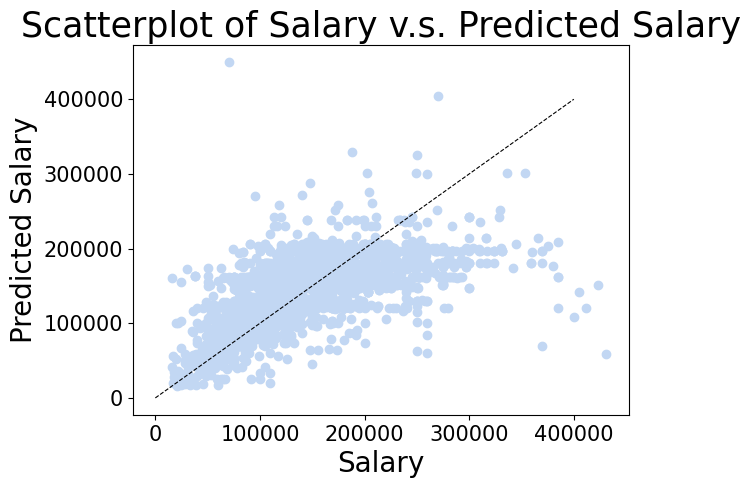

In [39]:
model_dtr, results_dtr = dtr_model(X_train, X_test, y_train, y_test)
results__dtr_df = pd.DataFrame([results_dtr], columns=results_dtr.keys())

## Light GBM Model

Fitting 4 folds for each of 64 candidates, totalling 256 fits
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 5679, number of used features: 63
[LightGBM] [Info] Start training from score 149151.965663
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
==================Mean Squared Error==================
Mean squared error for train:  2268473534.0179505
Mean squared error for test:  2558522778.208719
==================Mean Absolute Error=================
Mean absolute error for train:  36275.78250518775
Mea

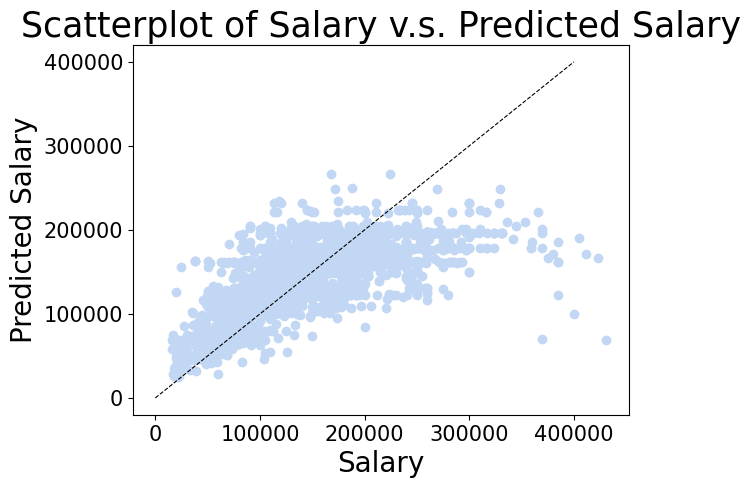

In [40]:
gridParams = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'n_estimators': [80,100],
    'num_leaves': [31],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['regression'],
    'reg_alpha': [1, 1.2],
    'reg_lambda': [1, 1.2]
}
model_lgbm, results_lgbm = lgbm_model(X_train, X_test, y_train, y_test, gridParams)
results__lgbm_df = pd.DataFrame([results_lgbm], columns=results_lgbm.keys())

In [41]:
concat_df = pd.concat([results__lr_df, results__lasso_df, results__ridge_df,\
            results__dtr_df, results__lgbm_df], axis=0)
concat_df.index =['Linear','Lasso', 'Ridge',"DecisionTree",'Light GBM']
concat_df

,Mean Squared Error for Train,Mean squared error for test,Mean Absolute Error for Train,Mean absolute error for test,R Squared for Train,R square for test
Linear,2.272718e+09,1.537610e+25,36380.470131,2.343019e+11,0.441142,-3.689033e+15
Lasso,2.367119e+09,2.616792e+09,37378.614703,3.847573e+04,0.417929,3.721795e-01
Ridge,2.285111e+09,2.624298e+09,36661.739571,3.852192e+04,0.438095,3.703785e-01
DecisionTree,1.954094e+09,2.801964e+09,32145.718023,3.908403e+04,0.519491,3.277530e-01
Light GBM,2.268474e+09,2.558523e+09,36275.782505,3.787369e+04,0.442186,3.861594e-01
